# 27. Recurrent Neural Networks

In [28]:
import pandas as pd

## Loading Data

In [29]:
timeserise_revenue = pd.read_csv('/Volumes/Library/SynologyDrive/data/AI_Cheats/time_serise_revenue.csv')
sales_data = pd.read_csv('/Volumes/Library/SynologyDrive/data/AI_Cheats/time_serise_sale.csv')

timeserise_revenue.drop(axis=1, columns='Unnamed: 0', inplace=True)

timeserise_revenue.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_51,day_52,day_53,day_54,day_55,day_56,day_57,day_58,day_59,day_60
0,2.622866,2.657832,2.771121,2.815845,2.876267,2.859229,2.844758,2.793797,2.736443,2.655966,...,1.228701,1.290414,1.474886,1.563295,1.736197,1.797285,1.978940,2.198979,2.277908,2.403300
1,2.057578,2.089561,2.138827,2.189964,2.224312,2.213340,2.197103,2.079228,2.072745,1.951091,...,1.880965,1.869619,1.872043,1.854963,1.846967,1.878265,1.868918,1.877923,1.975341,1.959734
2,2.485055,2.349254,2.284784,2.142335,2.048803,1.990668,1.965783,1.866983,1.816916,1.816590,...,2.714773,2.792819,2.788505,2.879778,2.873212,2.854421,2.863193,2.773218,2.708913,2.590657
3,2.053928,2.121919,2.148003,2.179574,2.161062,2.124168,2.153791,2.097816,1.953759,1.962948,...,1.861072,1.875642,1.782617,1.768666,1.876252,1.815870,1.870878,1.923176,2.025993,2.048272
4,1.702631,1.825995,2.038047,2.194083,2.313903,2.417883,2.567613,2.650782,2.729691,2.876534,...,1.258760,1.137150,1.109007,1.104999,1.150137,1.204513,1.221350,1.327023,1.387304,1.557363


In [30]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random
import matplotlib.pyplot as plt
plt.style.use('default')
# Generating a noisy multi-sin wave 

In [31]:
class FullyConnected(nn.Module):
    def __init__(self, x_size, hidden_size, output_size):
        super(FullyConnected, self).__init__()
        self.hidden_size = hidden_size

        self.linear_with_tanh = nn.Sequential(
            nn.Linear(10, self.hidden_size),
            nn.Tanh(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Tanh(),
            nn.Linear(self.hidden_size, output_size)
        )
        
    def forward(self, x):
        yhat = self.linear_with_tanh(x)
        
        return yhat

In [32]:
class SimpleRNN(nn.Module):
    def __init__(self, x_size, hidden_size, n_layers, batch_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        #self.inp = nn.Linear(1, hidden_size) 
        self.rnn = nn.RNN(x_size, hidden_size, n_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size) # 10 in and 10 out

    def forward(self, inputs, hidden=None):
        hidden = self.__init__hidden()
        #print("Forward hidden {}".format(hidden.shape))
        #print("Forward inps {}".format(inputs.shape))
        output, hidden = self.rnn(inputs.float(), hidden.float())
        #print("Out1 {}".format(output.shape))
        output = self.out(output.float());
        #print("Forward outputs {}".format(output.shape))

        return output, hidden

    def __init__hidden(self):
        hidden = torch.zeros(self.n_layers, self.batch_size, self.hidden_size, dtype=torch.float64)
        return hidden

## Set dataset

In [33]:
sales_data.drop(axis=1, columns='Unnamed: 0', inplace=True)
source_data = sales_data

## Fully Connected Model

In [34]:
n_epochs = 30
hidden_size = 2 # try to change this parameters 
n_layers = 1
batch_size = 5
seq_length = 10
n_sample_size = 50

x_size = 1

In [35]:
fc_model = FullyConnected(x_size, hidden_size, output_size=seq_length)
fc_model = fc_model.double()

In [36]:
criterion = nn.MSELoss()
optimizer = optim.SGD(fc_model.parameters(), lr=0.01)

fc_losses = np.zeros(n_epochs) 

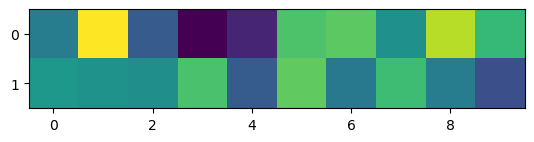

In [37]:
plt.imshow(fc_model.state_dict()['linear_with_tanh.0.weight'])

In [38]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [39]:
source_data

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,2.291574,2.882838,3.581805,4.013875,1.109924,2.834247,2.625045,2.196884,4.208887,2.969051,...,1.242250,2.771072,3.778143,3.161634,3.792645,2.015481,2.826184,2.520788,2.637210,2.748923
1,0.609664,2.523604,2.609537,3.695997,3.399272,2.616612,1.651935,1.348295,3.862523,2.061477,...,2.477505,2.284513,3.461783,3.101052,3.442420,1.915776,2.426168,1.662855,2.481925,2.411202
2,3.422793,1.812651,-0.097966,1.724064,3.093660,1.781278,2.849946,2.949707,3.560835,2.813926,...,2.219667,2.359834,1.932029,2.731947,1.836245,1.219933,1.222740,1.720052,2.169939,2.161702
3,3.372283,2.577254,3.854308,3.449679,2.517676,2.635679,2.352706,2.856216,1.948434,1.484706,...,1.670912,0.909113,3.216652,1.775346,3.270484,2.399709,3.032071,1.703666,1.750585,1.821736
4,2.997727,1.799415,3.648090,2.391567,2.376778,1.864717,0.408062,2.346726,3.260303,2.645002,...,2.304058,3.038905,2.038733,2.825186,2.232937,2.509050,2.881796,-1.712131,2.140366,1.926818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15047,1.952726,1.547637,1.902789,0.813261,2.600979,2.910638,2.878396,0.594216,3.526187,3.275296,...,0.486073,3.336252,3.307270,3.026835,1.472116,3.220792,2.664044,1.546153,3.026948,2.611774
15048,0.652824,3.589191,3.257707,2.821276,2.185937,2.534801,-0.774375,3.835695,3.776809,3.502364,...,2.684153,1.384912,3.184570,2.832941,2.092033,2.606198,0.753193,3.160599,3.085800,2.814394
15049,3.833707,3.548071,3.194160,1.993437,3.013547,1.825047,2.305196,0.522475,3.126647,3.231283,...,2.928937,1.633754,3.078598,2.466563,0.489380,3.518725,3.406466,3.031342,1.852089,3.005631
15050,3.186439,1.703232,3.196591,2.407803,-0.474370,3.879943,3.762408,3.415669,1.790529,3.280106,...,1.642612,2.387770,2.149893,0.688463,3.150805,3.242209,2.972728,1.196053,3.340991,2.921557


In [40]:
source_data.values.shape

(15052, 52)

In [41]:
source_data.values

array([[ 2.29157429,  2.88283833,  3.58180474, ...,  2.52078778,
         2.63721001,  2.74892268],
       [ 0.60966411,  2.52360427,  2.60953707, ...,  1.66285479,
         2.48192522,  2.41120153],
       [ 3.42279275,  1.81265116, -0.09796635, ...,  1.72005177,
         2.16993942,  2.16170153],
       ...,
       [ 3.83370716,  3.54807088,  3.1941596 , ...,  3.0313419 ,
         1.85208859,  3.00563077],
       [ 3.18643937,  1.70323164,  3.19659131, ...,  1.19605309,
         3.34099104,  2.9215574 ],
       [ 3.10427003,  2.82717086,  1.17642808, ...,  1.33781619,
         2.7146877 ,  2.34349413]], shape=(15052, 52))

In [42]:
from icecream import ic

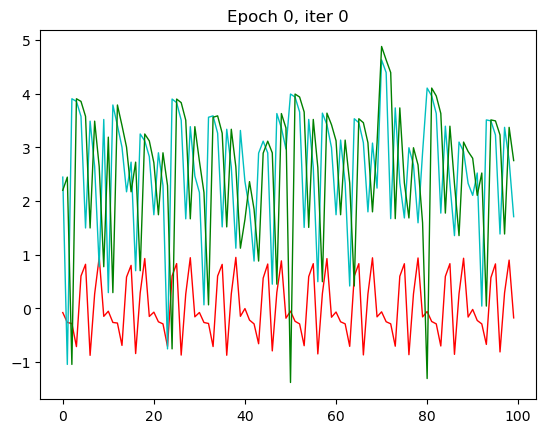

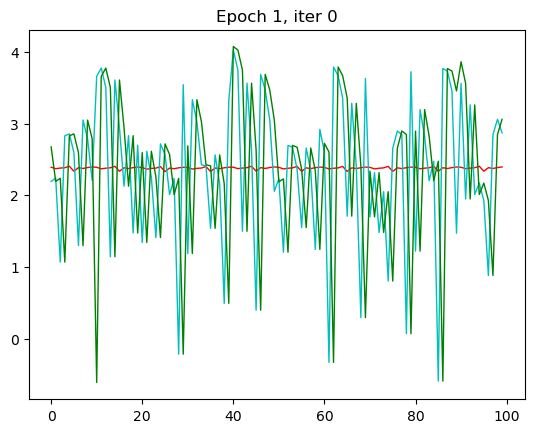

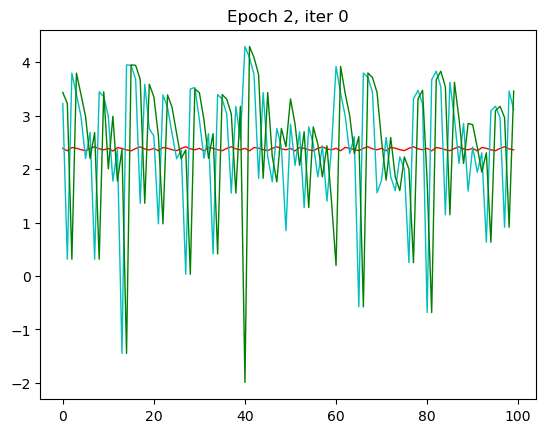

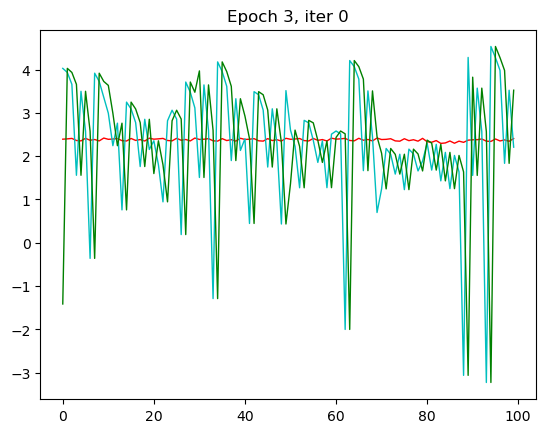

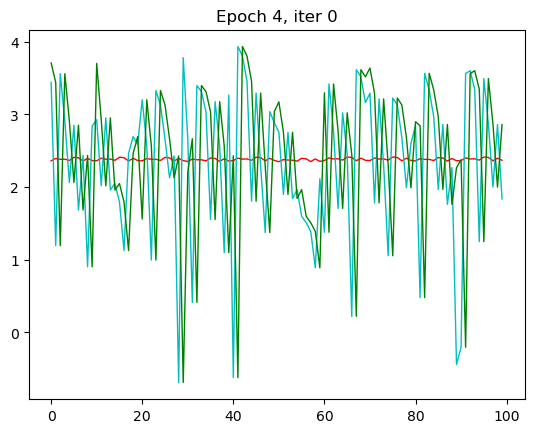

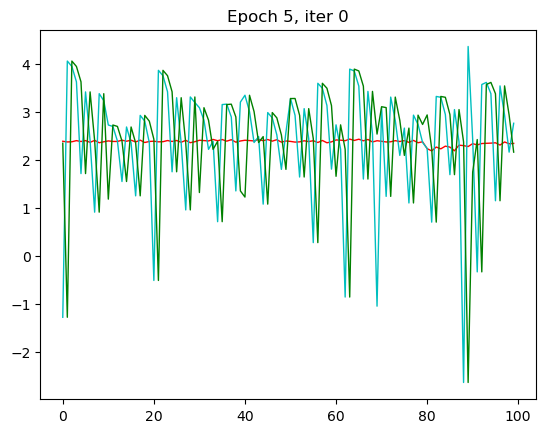

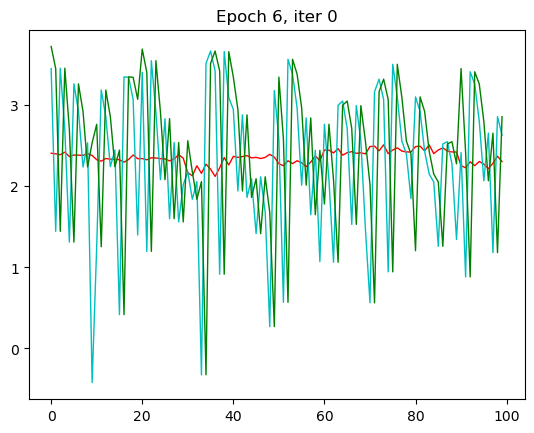

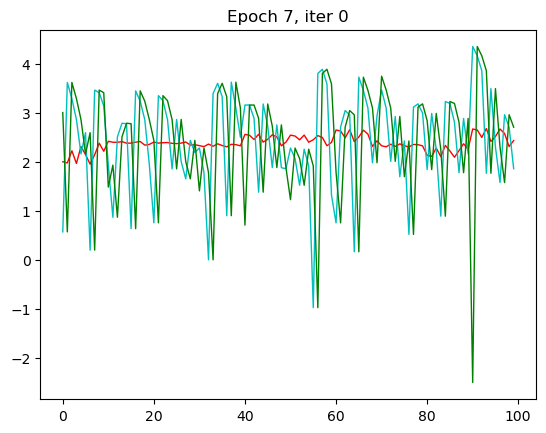

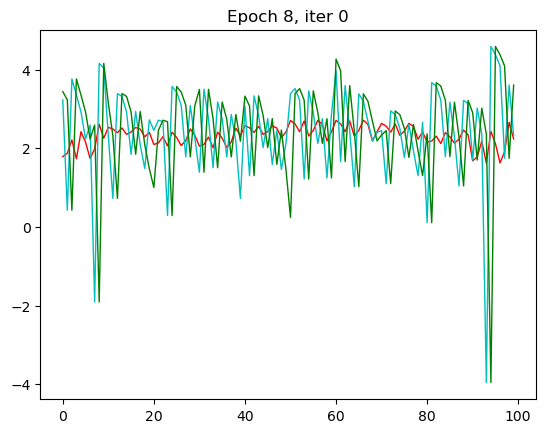

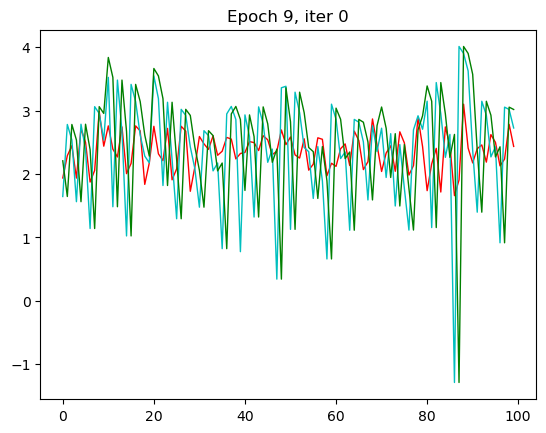

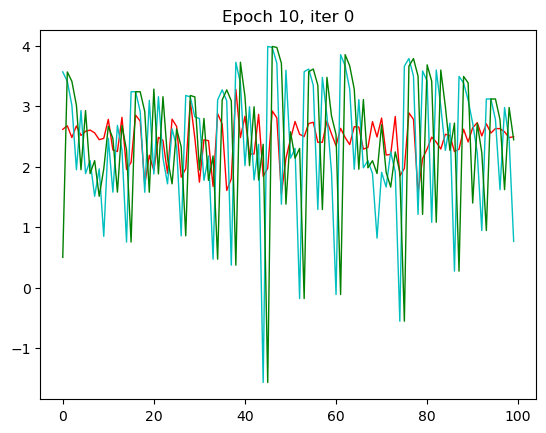

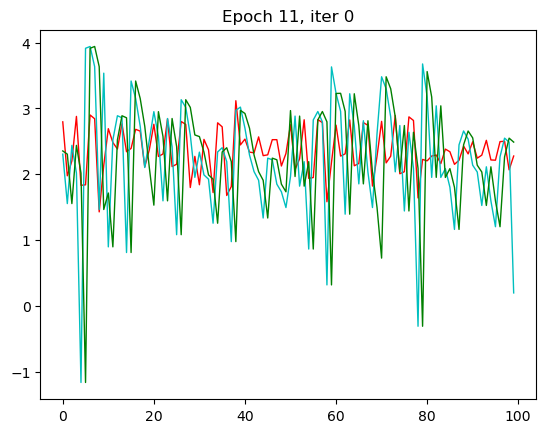

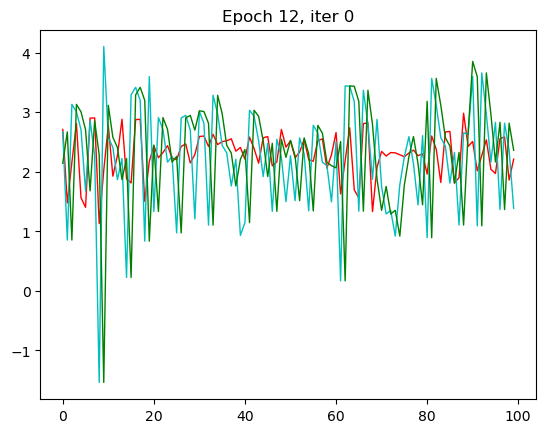

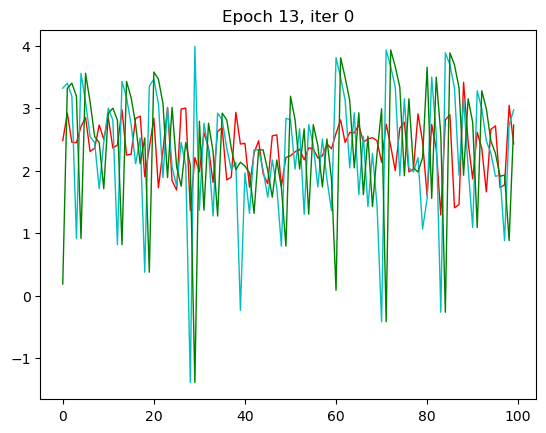

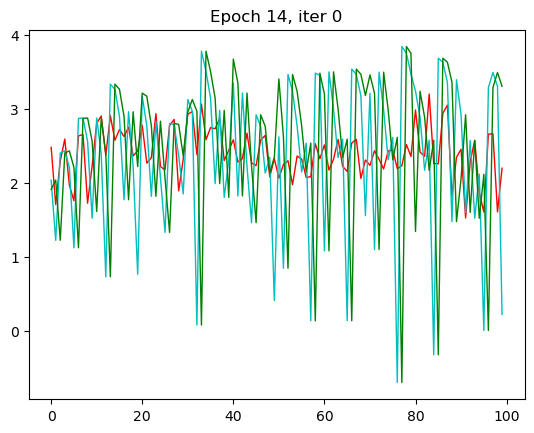

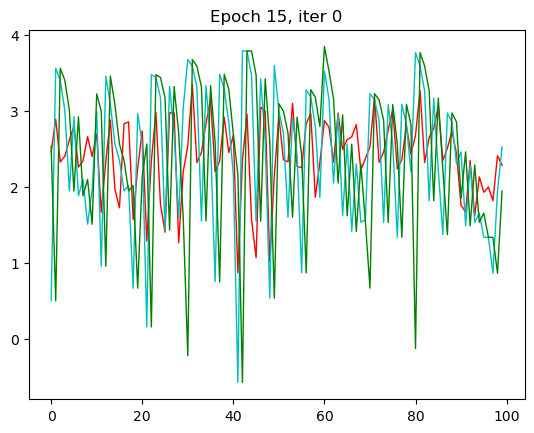

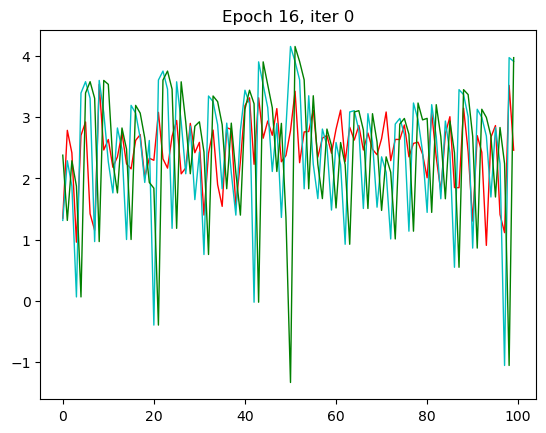

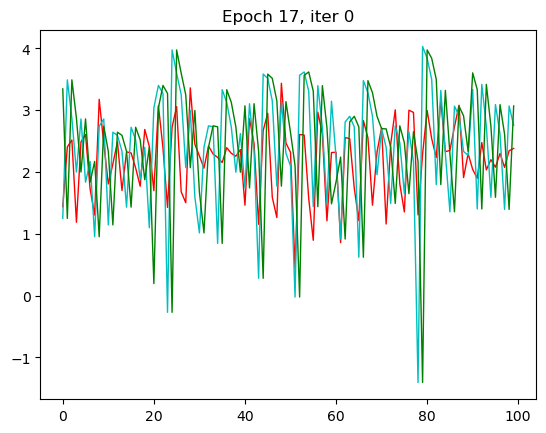

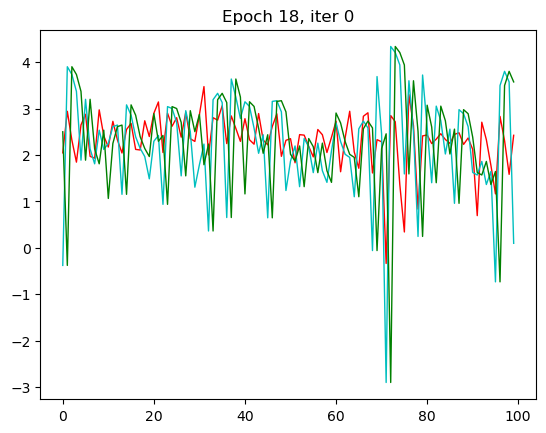

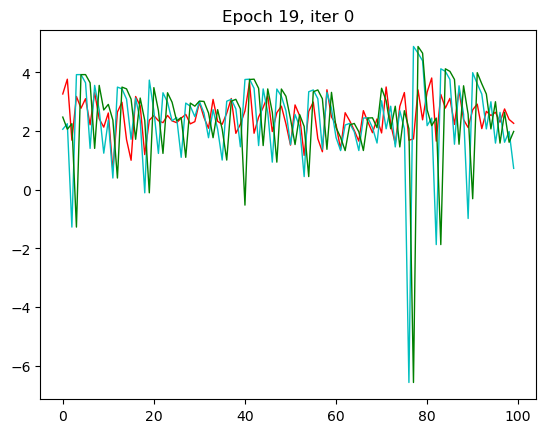

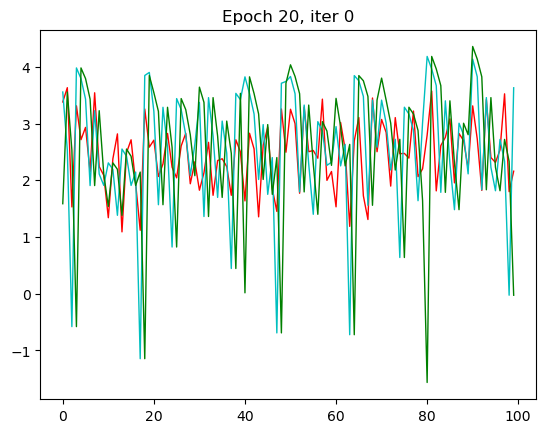

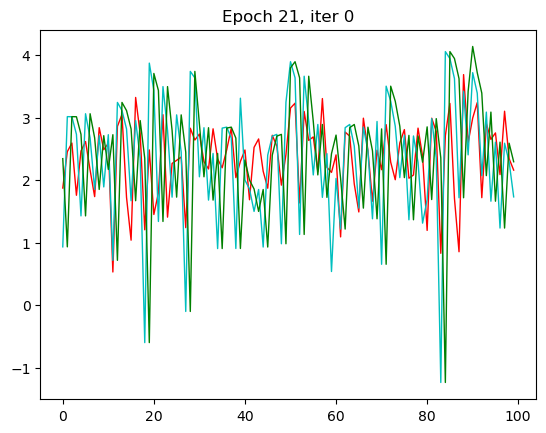

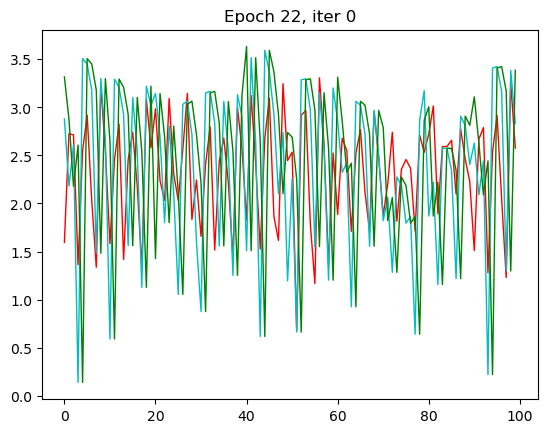

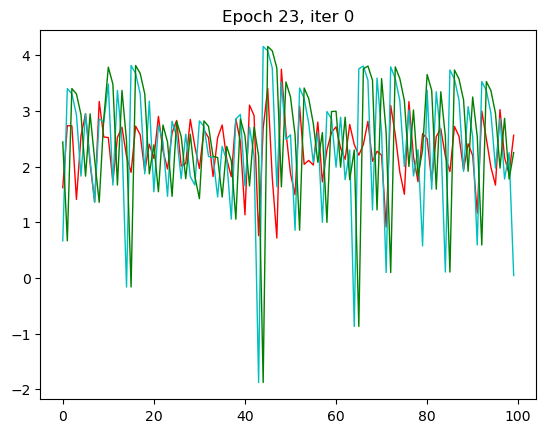

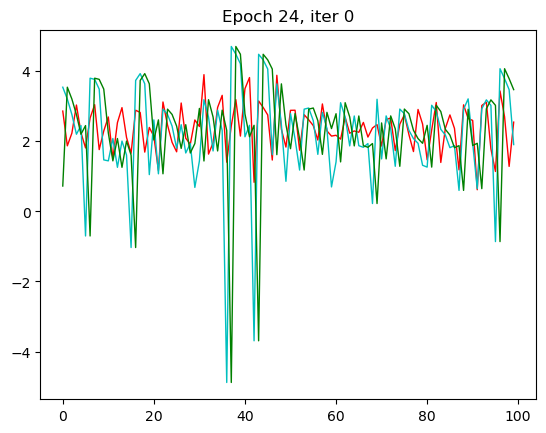

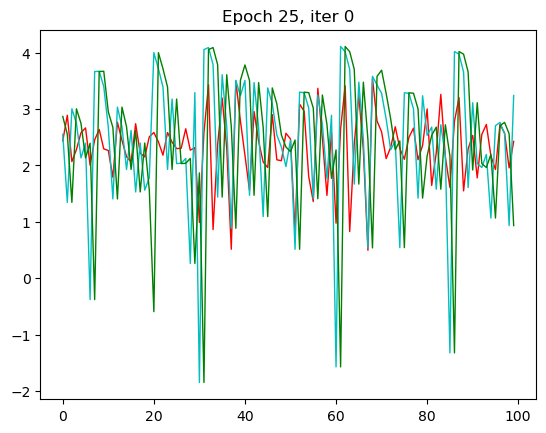

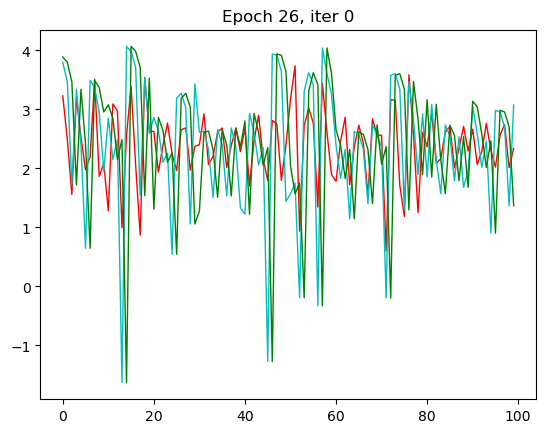

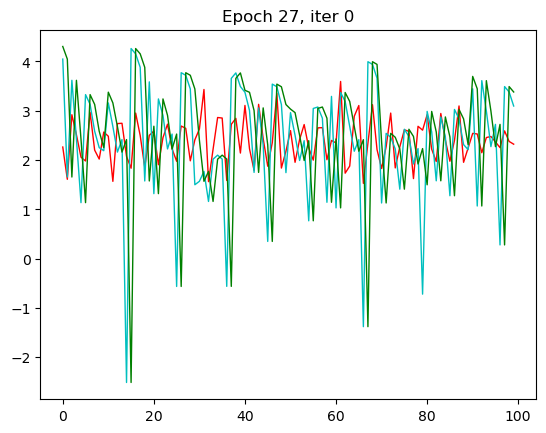

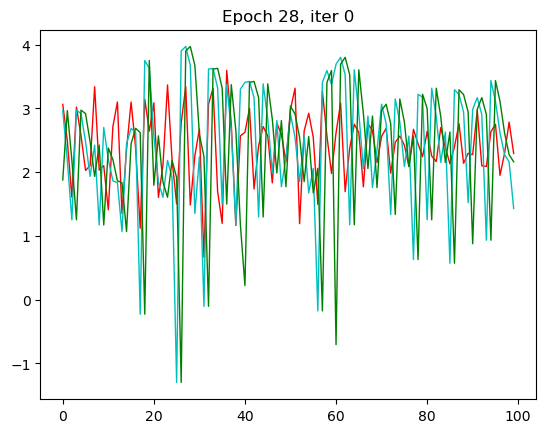

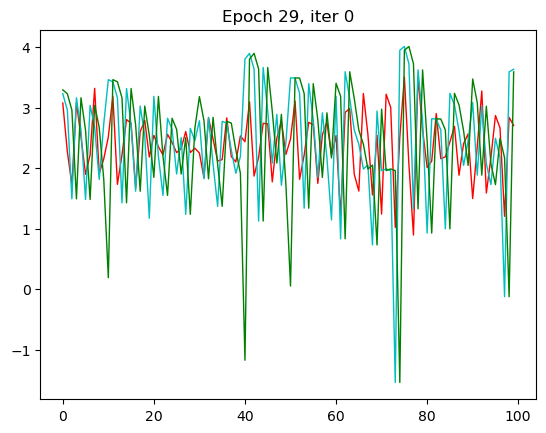

In [43]:
data_loader = torch.utils.data.DataLoader(source_data.values, batch_size=seq_length, shuffle=True)

for epoch in range(n_epochs):
    epoch_losses = []
    for iter_, t in enumerate(data_loader):
        random_index = random.randint(0, t.shape[-1] - seq_length - 1)
        train_x = t[:, random_index: random_index+seq_length]
        train_y = t[:, random_index + 1: random_index + seq_length + 1]

        outputs = fc_model(train_x.double())

        optimizer.zero_grad()
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.detach())
        if iter_  == 0:
            plt.clf()
            plt.ion()
            plt.title("Epoch {}, iter {}".format(epoch, iter_))
            plt.plot(torch.flatten(outputs.detach()),'r-',linewidth=1,label='Output')
            plt.plot(torch.flatten(train_y),'c-',linewidth=1,label='Label')
            plt.plot(torch.flatten(train_x),'g-',linewidth=1,label='Input')
            plt.draw()
            plt.pause(0.05)
    fc_losses[epoch] = np.mean(epoch_losses)

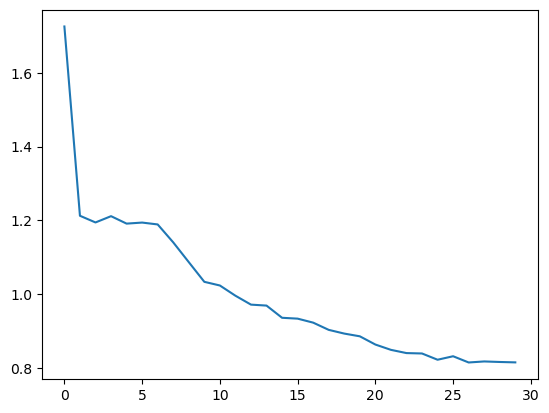

In [44]:
plt.plot(fc_losses)

## RNN Model

In [45]:
n_epochs = 30
hidden_size = 2 # try to change this parameters 
n_layers = 1
batch_size = 5
seq_length = 10
n_sample_size = 50

x_size = 1
output_size = 1

hidden = None

In [46]:
#rnn_model = SimpleRNN(x_size, hidden_size, n_layers, seq_length, output_size)
rnn_model = SimpleRNN(x_size, hidden_size, n_layers, seq_length, output_size)

In [47]:
criterion = nn.MSELoss()
optimizer = optim.SGD(rnn_model.parameters(), lr=0.01)

rnn_losses = np.zeros(n_epochs) 

In [48]:
data_loader = torch.utils.data.DataLoader(source_data.values, batch_size=seq_length, shuffle=True)

for epoch in range(n_epochs):
    for iter_, t in enumerate(data_loader):
        if t.shape[0] != seq_length: continue 

        random_index = random.randint(0, t.shape[-1] - seq_length - 1)
        train_x = t[:, random_index: random_index+seq_length]
        train_y = t[:, random_index + 1: random_index + seq_length + 1]

        outputs, hidden = rnn_model(train_x.double().unsqueeze(2), hidden)

        optimizer.zero_grad()
        loss = criterion(outputs.double(), train_y.double().unsqueeze(2))
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.detach())
        # if iter_ == 0:
        #     plt.clf()
        #     plt.ion()
        #     plt.title("Epoch {}, iter {}".format(epoch, iter_))
        #     plt.plot(torch.flatten(outputs.detach()),'r-',linewidth=1,label='Output')
        #     plt.plot(torch.flatten(train_y),'c-',linewidth=1,label='Label')
        #     plt.plot(torch.flatten(train_x),'g-',linewidth=1,label='Input')
        #     plt.draw()
        #     plt.pause(0.05)
    rnn_losses[epoch] = np.mean(epoch_losses)

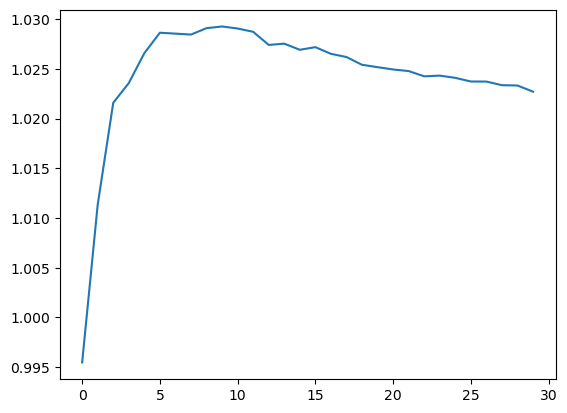

In [49]:
plt.plot(rnn_losses)

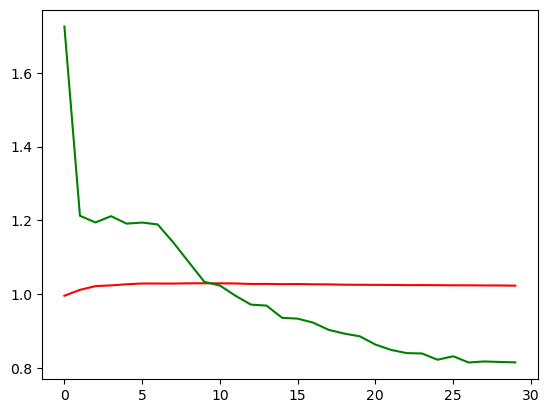

In [50]:
plt.plot(rnn_losses, c='red')
plt.plot(fc_losses, c='green')